# Python Group 8 Assignment

Members: Camille Blain-Coallier, Federico C. Loguercio, Giulio De Felice, Nayla Fakhoury, Alejandro Koury, Victor Vu Duy Phuoc, Vikas Agarwal


For this project, we were given two datasets from Kaggle https://www.kaggle.com/marklvl/bike-sharing-dataset/home containing information about the Bike Sharing service in Washington D.C. "Capital Bikeshare"

One dataset contains hourly data and the other one has daily data from the years 2011 and 2012.

The following variables are included in the data:

* instant: Record index
* dteday: Date
* season: Season (1:springer, 2:summer, 3:fall, 4:winter)
* yr: Year (0: 2011, 1:2012)
* mnth: Month (1 to 12)
* hr: Hour (0 to 23, only available in the hourly dataset)
* holiday: whether day is holiday or not (extracted from Holiday Schedule)
* weekday: Day of the week
* workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit: (extracted from Freemeteo)
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered (Our target variable)

We are tasked with building a predictive model that can determine how many people will use the service on an hourly basis, therefore we take the first 5 quarters of the data for our training dataset and the last quarter of 2012 will be the holdout against which we perform our validation. Since that data was not used for training, we are sure that the evaluation metric that we get for it (R2 score) is an objective measurement of its predictive power.

### Planning

Initially, we decided to separate the project in 4 steps:

Data Loading and Exploratory Data Analysis: Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. Also, the creation of different types of plots in order to help us understand the data and make the model creation easier.

Data Preparation and Feature Engineering: Once we have the data, we would need to prepare it for the modeling stage, standardizing it, changing data types, dropping features, among others. Later, a process of creating features and selecting others based on a number of different criteria like correlation, would also need to be performed.

Modeling and Tuning: Once we have the data ready, the modeling stage begins, making use of different models (and ensembles) and a strong pipeline with different transformers, we would hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

Results and Conclusions: Finally, with our tuned models, we would predict against the test set we decided to separate initially, then plotting those results against their actual values to determine the performance of the model, and finally, outlining our conclusions after this extensive project.

Since there are so many tasks to be performed, we decided to split some of them between the members of our group.

Federico and Camille were in charge of creating the different plots you see through the project, Nayla and Victor were in charge of the different data preparation steps, Federico Giulio and Alejandro were in charge of the modeling part since it was arguably the longest one, and Vikas was in charge of extracting the different processes inside our code to functions in a file outside of the notebook so as to produce a clean report that can be read by everyone interested in it without getting lost in unnecessary details.


### Notes

For the code to run, you must install the following extensions:
* Seaborn (aesthetic plots) Version 0.9.0
* Xgboost (boosting model) Version 0.82
* Gplearn (genetic features) Version 0.3.0

The following code performs the task of installing these libraries, if you wish to do so you may uncomment the cell and run it

Also, a file that is included inside the zip folder called helpers.py is needed to run the code, this file contains the different functions that were created throught the project in a neat folder that declutters the botebook

In [12]:
# ! pip install seaborn==0.9.0
# ! pip install xgboost==0.82
# ! pip install gplearn==0.3.0

Now we import the necessary libraries

In [13]:
import warnings
import numpy as np
import pandas as pd
import helpers as hp
import seaborn as sns
import plotly.tools as tls
import plotly.plotly as py
from sklearn.base import clone
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from gplearn.genetic import SymbolicTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as metric_scorer
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, PowerTransformer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

tls.set_credentials_file(username='alejandro321', api_key='yBVtyuhfWpl3rH4TrOGE')
warnings.filterwarnings('ignore')

### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed

In [14]:
SEED = 1
DATA_PATH = 'https://gist.githubusercontent.com/f-loguercio/f5c10c97fe9afe58f77cd102ca81719b/raw/99fb846b22abc8855de305c2159a57a77c9764cf/bikesharing_hourly.csv'
DATA_PATH2 = 'https://gist.githubusercontent.com/f-loguercio/14ac934fabcca41093a51efef335f8f2/raw/58e00b425c711ac1da2fb75f851f4fc9ce814cfa/bikesharing_daily.csv'
PREC_PATH = 'https://gist.githubusercontent.com/akoury/6fb1897e44aec81cced8843b920bad78/raw/b1161d2c8989d013d6812b224f028587a327c86d/precipitation.csv'
TARGET_VARIABLE = 'cnt'
ESTIMATORS = 50

### Data Loading

Here we load the necessary data, print its first rows and describe its contents

In [15]:
def read_data(input_path):
    return pd.read_csv(input_path, parse_dates=[1])

data = read_data(DATA_PATH)
data_daily = read_data(DATA_PATH2)

data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [16]:
data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### Precipitation Data

In order to generate our model, we will add precipitation data obtained from the National Climatic Data Center https://www.ncdc.noaa.gov/cdo-web/datasets

However, since most of the values are 0, we will convert them to a boolean that determines if rain was present or not at that specific hour

In [17]:
precipitation = read_data(PREC_PATH)
data = pd.merge(data, precipitation,  how='left', on=['dteday','hr'])
data['precipitation'].fillna(0, inplace=True)
data['precipitation'][data['precipitation'] > 0] = 1
data['precipitation'] = data['precipitation'].astype(int).astype('category')

data_hourly = data.copy()
data_hourly = data_hourly[data_hourly['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))]

### Data types

We review the data types for each column

In [18]:
data.dtypes

instant                   int64
dteday           datetime64[ns]
season                    int64
yr                        int64
mnth                      int64
hr                        int64
holiday                   int64
weekday                   int64
workingday                int64
weathersit                int64
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
casual                    int64
registered                int64
cnt                       int64
precipitation          category
dtype: object

### Missing Data

We check if there is any missing data

In [19]:
hp.missing_data(data)

,Total,Percent
precipitation,0,0.0
cnt,0,0.0
dteday,0,0.0
season,0,0.0
yr,0,0.0
mnth,0,0.0
hr,0,0.0
holiday,0,0.0
weekday,0,0.0
workingday,0,0.0


### Converting columns to their true categorical type
Now we convert the data types of numerical columns that are actually categorical

In [20]:
data = hp.convert_to_category(data, data.iloc[:,2:10])

data.dtypes

instant                   int64
dteday           datetime64[ns]
season                 category
yr                     category
mnth                   category
hr                     category
holiday                category
weekday                category
workingday             category
weathersit             category
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
casual                    int64
registered                int64
cnt                       int64
precipitation          category
dtype: object

### Adding lag of registered users

In order to improve the long term prediction efficacy of our model we add lags of the number of users for the previous hour and the previous 24 hours

In [21]:
def add_lag(df, col, lag):
    lagged = df[col].shift(lag).rename(str(col) + '_' + str(lag))
    lagged[0:(lag)] = lagged[lag:(lag*2)]
    return lagged

data = pd.concat([data, add_lag(data, 'registered', 1), add_lag(data, 'registered', 24)], axis = 1)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,precipitation,registered_1,registered_24
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1,13.0,13.0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1,13.0,32.0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1,32.0,27.0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1,27.0,10.0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1,10.0,1.0


### Dropping Columns

We drop casual and registered columns

In [22]:
data = hp.drop_columns(data, ['casual', 'registered'])
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,precipitation,registered_1,registered_24
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,1,13.0,13.0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,1,13.0,32.0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,1,32.0,27.0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,1,27.0,10.0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,1,10.0,1.0


## Exploratory Data Analysis

Here we will perform all of the necessary data analysis, with different plots that will help us understand the data and therefore, create a better model

We must specify that **all of this analysis is performed only on the training data**, so that we do not incur in any sort of bias when modeling

To start we define some color palettes to be used

In [23]:
palette_tot_cas_reg = ['darkgreen', 'darkred', 'darkblue']

palette_cas = ['darkred', 'salmon']
palette_reg = ['darkblue', 'skyblue']

### Overall distribution of the target variable

In [24]:
data_hist = [go.Histogram(x=data_hourly['cnt'])]

py.iplot(data_hist, filename='basic histogram', color = 'darkgreen')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~alejandro321/0 or inside your plot.ly account where it is named 'basic histogram'


### Temperature Vs. Windspeed

In [25]:
trace = go.Scatter(
    x = data_hourly['atemp'],
    y = data_hourly['windspeed'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='windspeed'
    ),
    xaxis=go.layout.XAxis(
        title='temperature'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='basic-scatter')

### Hourly Humidity Average

In [26]:
trace = go.Scatter(
    x = data_hourly['hr'],
    y = data_hourly['hum'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='humidity'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_hr_hum')

### Average Casual User Usage

In [27]:
trace = go.Scatter(
    x = data_hourly['hr'],
    y = data_hourly['cnt']-data_hourly['registered'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='casual users'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_casual_hr')

### Average Registered User Usage

In [28]:
trace = go.Scatter(
    x = data_hourly['hr'],
    y = data_hourly['registered'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='registered users'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_casual_hr')

### Usage over time, by type of user and total

Text(0, 0.5, 'Users')

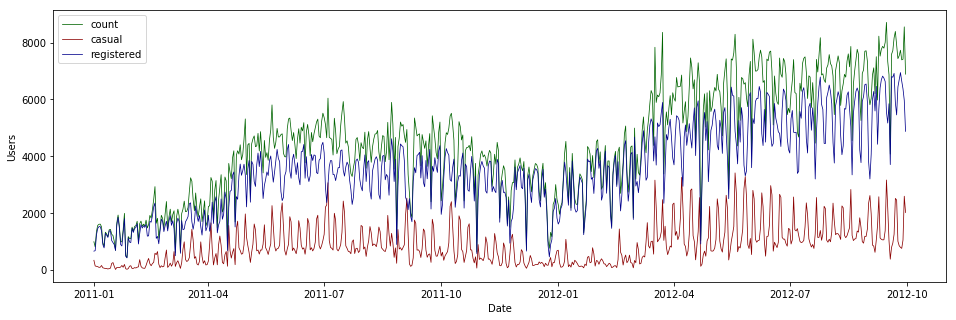

In [29]:
data_daily = data_daily[data_daily['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))]

data_daily = hp.convert_to_category(data_daily, data_daily.iloc[:,2:9])
data_daily.set_index('dteday')

plt.figure(figsize=(16, 5))

ax = sns.lineplot(data = data_daily, x = 'dteday', y = 'cnt', color='darkgreen', size = 1,label = 'count')
ax = sns.lineplot(data = data_daily, x = 'dteday', y = 'casual', color='darkred', size = 1, label = 'casual')
ax = sns.lineplot(data = data_daily, x = 'dteday', y = 'registered', color='darkblue', size = 1, label = 'registered')

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:1]+handles[3:4]+handles[6:7], labels[0:1]+labels[3:4]+labels[6:7], loc=2)
plt.xlabel('Date')
plt.ylabel('Users')

They all seem to be increasing and have some seasonality

### Monthly average usage

Text(0, 0.5, 'Users')

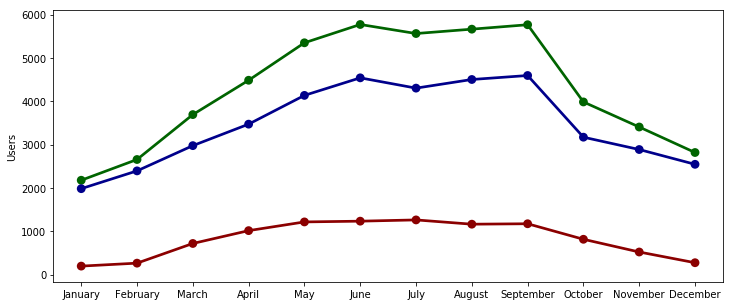

In [30]:
df_month = pd.DataFrame(data_daily.groupby("mnth")[["cnt", 'casual', 'registered']].mean()).reset_index()
months = pd.Series(["January","February","March","April","May","June","July","August","September","October","November","December"]).rename("months")
df_month = pd.concat([df_month, months], axis = 1)


plt.figure(figsize=(12, 5))
ax = sns.pointplot(data = df_month, x = "months", y = "cnt", color = 'darkgreen')
ax = sns.pointplot(data = df_month, x = "months", y = "casual", color = 'darkred')
ax = sns.pointplot(data = df_month, x = "months", y = "registered", color = 'darkblue')

plt.xlabel('')
plt.ylabel('Users')

No considerable differences in trends between casual and registered

### Weekly trend usage

Text(0, 0.5, 'Users')

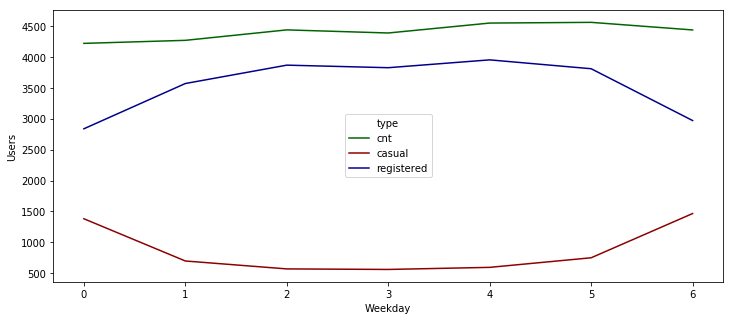

In [31]:
df_week = pd.DataFrame(data_daily.groupby("weekday")[["cnt", 'casual', 'registered']].mean()).reset_index()
df_week = pd.melt(df_week, id_vars = ['weekday'], value_vars = ['cnt', 'casual', 'registered'], var_name = 'type', value_name = 'users')

plt.figure(figsize=(12, 5))
ax = sns.lineplot(data = df_week, x = "weekday", y = "users", hue = "type", palette = palette_tot_cas_reg)
plt.xlabel('Weekday')
plt.ylabel('Users')

Casual and registered users follow exactly opposed trends throughout the week.

### Daily trend

**By type of users**

Text(0, 0.5, 'Users')

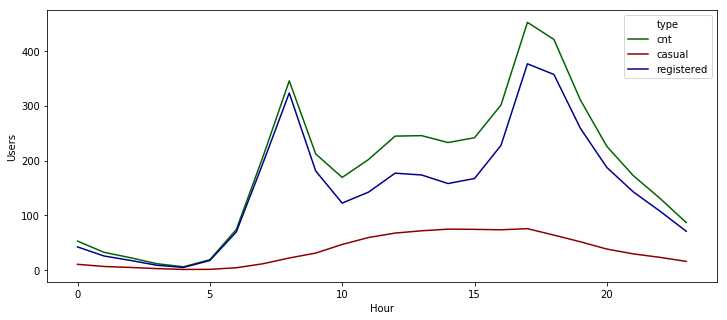

In [32]:
data_hourly = hp.convert_to_category(data_hourly, data_hourly.iloc[:,2:9])
data_hourly.set_index('dteday')

df_day = pd.DataFrame(data_hourly.groupby("hr")[["cnt", 'casual', 'registered']].mean()).reset_index()
df_day = pd.melt(df_day, id_vars = ['hr'], value_vars = ['cnt', 'casual', 'registered'], var_name = 'type', value_name = 'users')

plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day, x = "hr", y = "users", hue = "type", palette = palette_tot_cas_reg)

plt.xlabel('Hour')
plt.ylabel('Users')

**Weekends compared with workingdays**

Text(0, 0.5, 'Users')

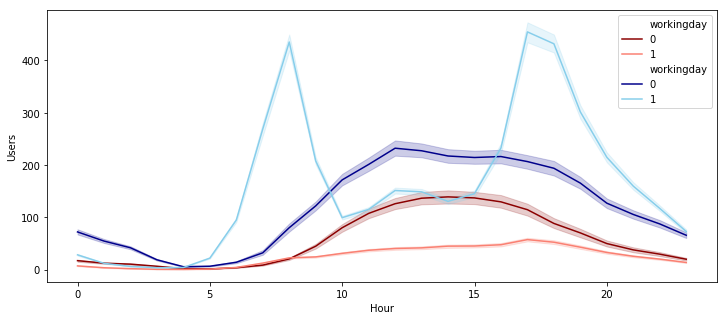

In [33]:
plt.figure(figsize=(12, 5))
sns.lineplot(data = data_hourly, x = "hr", y = "casual", hue = 'workingday', palette = palette_cas)
sns.lineplot(data = data_hourly, x = "hr", y = "registered", hue = 'workingday', palette = palette_reg)
plt.xlabel('Hour')
plt.ylabel('Users')

### Temperature effect on casual users

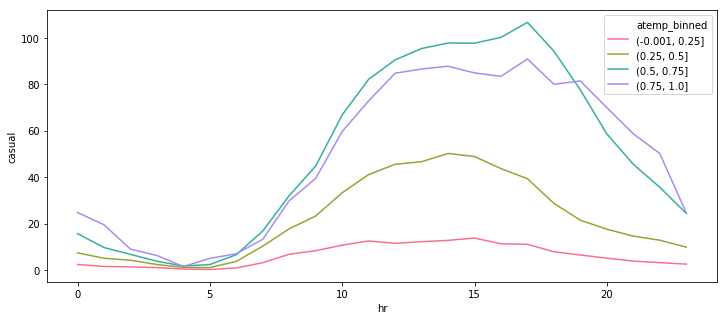

In [34]:
atemp_binned = pd.cut(x = data_hourly['atemp'], bins = 4).rename('atemp_binned')
data_hourly_binned = pd.concat([data_hourly, atemp_binned], axis = 1)

df_day_by_day_atemp = pd.DataFrame(data_hourly_binned.groupby(["hr", "atemp_binned"])[["cnt", 'casual', 'registered']].mean()).reset_index()
df_day_by_day_atemp.head()

plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day_by_day_atemp, x = 'hr', y = 'casual', hue = 'atemp_binned', palette = 'husl')

### Temperature effect on registered users

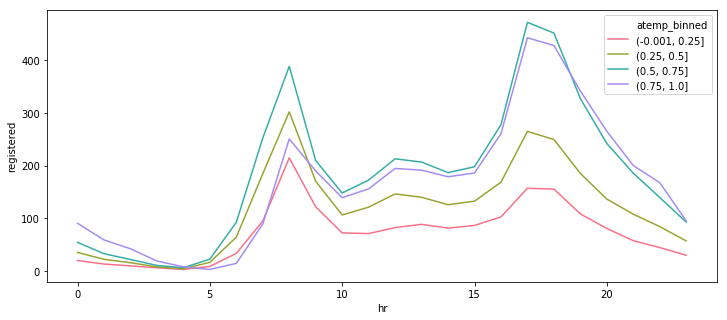

In [35]:
plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day_by_day_atemp, x = 'hr', y = 'registered', hue = 'atemp_binned', palette = 'husl')

As you can see, the effect is much more pronounced on the casual users

### Temperature Vs. Usage on working days for casual users

Text(0.5, 1.0, 'Casual Users')

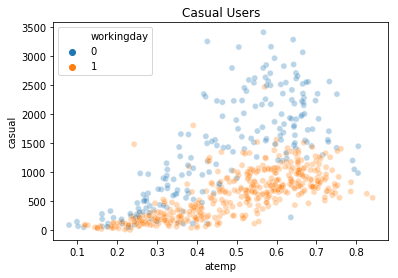

In [36]:
sns.scatterplot(data = data_daily, x = 'atemp', y = 'casual', hue = 'workingday', alpha = .3)
plt.title('Casual Users')

### Temperature Vs. Usage on working days for registered users

Text(0.5, 1.0, 'Registered Users')

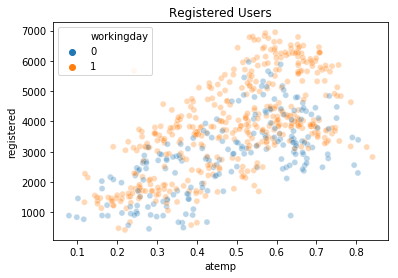

In [37]:
sns.scatterplot(data = data_daily, x = 'atemp', y = 'registered', hue = 'workingday', alpha = .3)
plt.title('Registered Users')

As we can see, temperature does affect casual user usage, but registered users do not seem to mind the temperature

### Precipitation Vs. Usage throughout the day

Text(0, 0.5, 'Users')

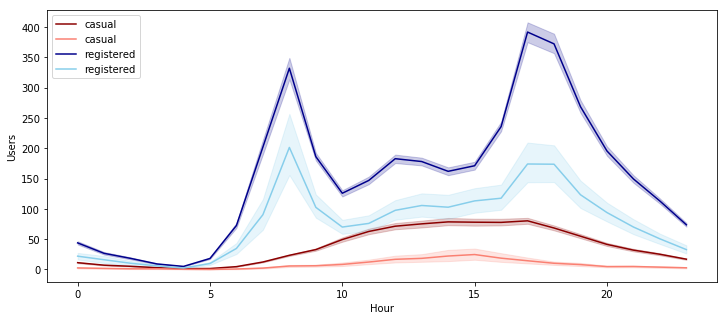

In [38]:
plt.figure(figsize=(12, 5))
ax = sns.lineplot(data = data_hourly, x = "hr", y = "casual", hue = 'precipitation', palette = palette_cas, label = 'casual')

ax = sns.lineplot(data = data_hourly, x = "hr", y = "registered", hue = 'precipitation', palette = palette_reg, label = 'registered')

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2]+handles[5:7], labels[0:2]+labels[5:7], loc=2)
plt.xlabel('Hour')
plt.ylabel('Users')

## Baseline

A basic linear model is created in order to set a baseline which further models will be compared against

In [39]:
base_holdout = data[data['dteday'].isin(pd.date_range('2012-10-01','2012-12-31'))].copy()
base_holdout = hp.drop_columns(base_holdout, ['dteday'])
base_data = data[data['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))]
base_data = hp.drop_columns(data, ['dteday'])

X_train = base_data.loc[:, base_data.columns != TARGET_VARIABLE]
y_train = base_data.loc[:, TARGET_VARIABLE]
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(base_holdout.loc[:, base_holdout.columns != TARGET_VARIABLE])

y = base_holdout.loc[:, TARGET_VARIABLE]
score = metric_scorer(y, pred)
print('Baseline score: ' + str(score))

Baseline score: 0.7654147441709028


## Data Preparation and Feature Engineering

Multiple data preparation and feature engineering steps will be performed in order to improve the model's prediction power

### Extracting Day Variable

Here we extract the day from the date variable

In [12]:
def extract_day(df):
    df['day'] = df['dteday'].dt.day
    df = hp.convert_to_category(df, ['day'])
    return df

data = extract_day(data)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,precipitation,registered_1,registered_24,day
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,1,13.0,13.0,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,1,13.0,32.0,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,1,32.0,27.0,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,1,27.0,10.0,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,1,10.0,1.0,1


### Data Correlation

Now we will analyze correlation in the data for both numerical and categorical columns and plot them

The following columns are correlated with a threshold of 0.9: ['workingday', 'atemp']


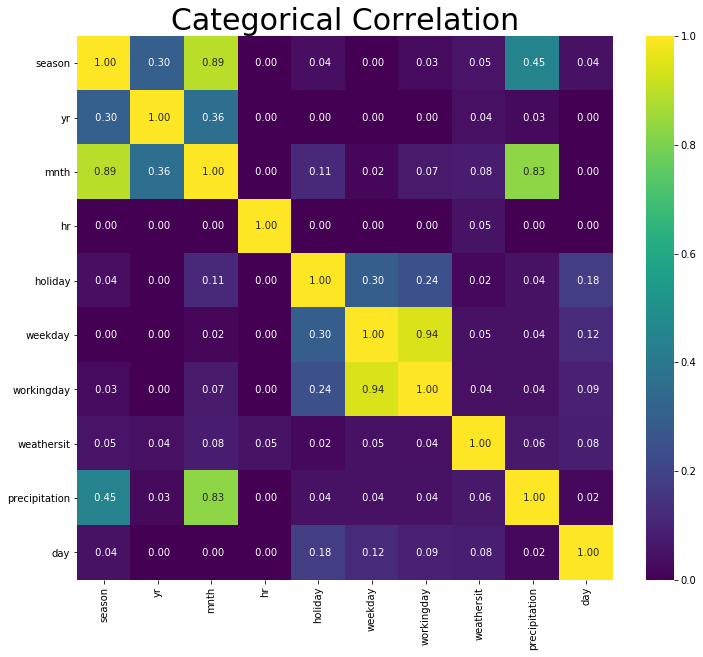

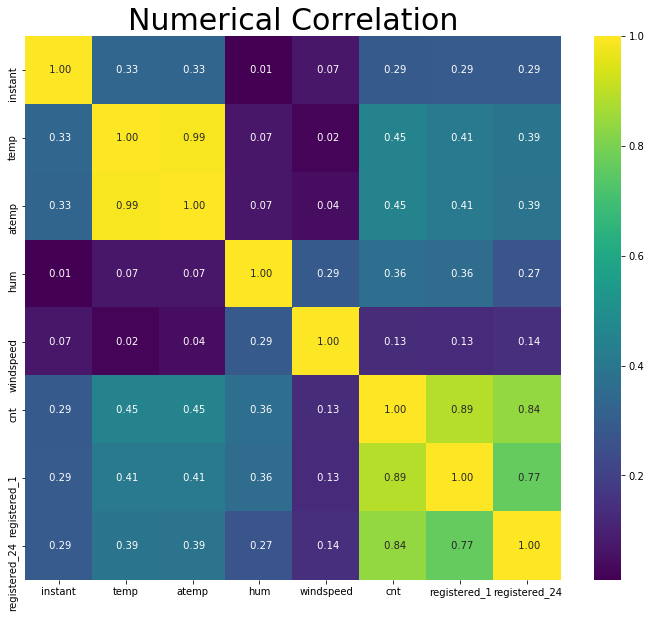

In [13]:
training_data = data[data['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))].copy()
correlated_cols, categoric_cols, numeric_cols = hp.correlated(training_data, 0.9)

Now we drop the correlated columns

In [14]:
data = hp.drop_columns(data, correlated_cols)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,weathersit,temp,hum,windspeed,cnt,precipitation,registered_1,registered_24,day
0,1,2011-01-01,1,0,1,0,0,6,1,0.24,0.81,0.0,16,1,13.0,13.0,1
1,2,2011-01-01,1,0,1,1,0,6,1,0.22,0.80,0.0,40,1,13.0,32.0,1
2,3,2011-01-01,1,0,1,2,0,6,1,0.22,0.80,0.0,32,1,32.0,27.0,1
3,4,2011-01-01,1,0,1,3,0,6,1,0.24,0.75,0.0,13,1,27.0,10.0,1
4,5,2011-01-01,1,0,1,4,0,6,1,0.24,0.75,0.0,1,1,10.0,1.0,1


### Outlier Removal

Now we will analyze and remove outliers considering two different methods, winsorizing and through Local Outlier Factor

In [15]:
hp.winsorize_data(data, training_data, hp.numericals(data, ['instant'])).describe()

,instant,temp,hum,windspeed,cnt,registered_1,registered_24
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.496987,0.627229,0.190098,189.463088,153.785488,153.692733
std,5017.0295,0.192556,0.192930,0.122340,181.387599,151.358461,151.394554
min,1.0000,0.020000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,4345.5000,0.340000,0.480000,0.104500,40.000000,34.000000,34.000000
50%,8690.0000,0.500000,0.630000,0.194000,142.000000,115.000000,115.000000
75%,13034.5000,0.660000,0.780000,0.253700,281.000000,220.000000,220.000000
max,17379.0000,1.000000,1.000000,0.850700,977.000000,886.000000,886.000000


In [16]:
data = hp.lof(data, hp.numericals(training_data, ['instant']))

data.describe()

Removing 34 records


,instant,temp,hum,windspeed,cnt,registered_1,registered_24
count,17345.000000,17345.000000,17345.000000,17345.000000,17345.000000,17345.000000,17345.000000
mean,8687.422427,0.496819,0.627399,0.190032,188.848429,153.208475,153.105506
std,5018.197067,0.192471,0.192842,0.122390,180.449330,150.403290,150.391254
min,1.000000,0.020000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,4342.000000,0.340000,0.480000,0.104500,40.000000,34.000000,34.000000
50%,8682.000000,0.500000,0.630000,0.194000,142.000000,115.000000,115.000000
75%,13036.000000,0.660000,0.780000,0.253700,280.000000,220.000000,220.000000
max,17379.000000,1.000000,1.000000,0.850700,977.000000,886.000000,886.000000


In the end, we chose Local Outlier Factor since it performed better

## Correcting Data Skewness and Standardizing
Now we will correct skewness and standardize numerical features

In [17]:
training_data = data[data['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))].copy()
pt = PowerTransformer(method='yeo-johnson', standardize = True).fit(hp.numericals(training_data, ['instant']))
data[hp.numericals(data, ['instant']).columns] = pt.transform(hp.numericals(data, ['instant']))
data.describe()

,instant,temp,hum,windspeed,cnt,registered_1,registered_24
count,17345.000000,17345.000000,17345.000000,17345.000000,17345.000000,17345.000000,17345.000000
mean,8687.422427,-0.081316,0.011109,-0.012083,188.848429,0.025824,0.026931
std,5018.197067,0.982628,0.986326,1.001615,180.449330,1.011304,1.011584
min,1.000000,-2.366304,-3.008269,-1.780402,1.000000,-2.130468,-2.130583
25%,4342.000000,-0.891728,-0.752706,-0.679869,40.000000,-0.751620,-0.749290
50%,8682.000000,-0.092475,0.005714,0.117311,142.000000,0.135080,0.137588
75%,13036.000000,0.744571,0.786674,0.589072,280.000000,0.754821,0.757039
max,17379.000000,2.639492,1.970144,3.702945,977.000000,2.555060,2.555029


### One Hot Encoding

We one hot encode categorical columns

In [18]:
data = hp.one_hot_encode(data, hp.categoricals(data, ['weekday']))

data.head()

,instant,dteday,weekday,temp,hum,windspeed,cnt,registered_1,registered_24,season_1,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,1,2011-01-01,6,-1.370975,0.945451,-1.780402,16,-1.250673,-1.248841,1,...,0,0,0,0,0,0,0,0,0,0
1,2,2011-01-01,6,-1.464876,0.892432,-1.780402,40,-1.250673,-0.785469,1,...,0,0,0,0,0,0,0,0,0,0
2,3,2011-01-01,6,-1.464876,0.892432,-1.780402,32,-0.787774,-0.883315,1,...,0,0,0,0,0,0,0,0,0,0
3,4,2011-01-01,6,-1.370975,0.628745,-1.780402,13,-0.885543,-1.359886,1,...,0,0,0,0,0,0,0,0,0,0
4,5,2011-01-01,6,-1.370975,0.628745,-1.780402,1,-1.361558,-1.959298,1,...,0,0,0,0,0,0,0,0,0,0


### Defining Final Holdout Set for Final Validation

In [19]:
holdout = data[data['dteday'].isin(pd.date_range('2012-10-01','2012-12-31'))].copy()
holdout_final_plots = holdout.copy() # will need this for plots at the end
holdout = hp.drop_columns(holdout, ['dteday'])
data = data[data['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))]
data = hp.drop_columns(data, ['dteday'])

### Underrepresented Features

Now we will remove underrepresented features, meaning those that in 99% of the records have a single value

In [20]:
data, holdout = hp.under_represented_features(data, 0.99, holdout)
data.head()

['weathersit_4'] underrepresented, removing


,instant,weekday,temp,hum,windspeed,cnt,registered_1,registered_24,season_1,season_2,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,1,6,-1.370975,0.945451,-1.780402,16,-1.250673,-1.248841,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,6,-1.464876,0.892432,-1.780402,40,-1.250673,-0.785469,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,6,-1.464876,0.892432,-1.780402,32,-0.787774,-0.883315,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,6,-1.370975,0.628745,-1.780402,13,-0.885543,-1.359886,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,6,-1.370975,0.628745,-1.780402,1,-1.361558,-1.959298,1,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Importance

Here we plot feature importance using a simple cross-validated random forest in order to have a sense of which features have the most importance

Feature ranking:


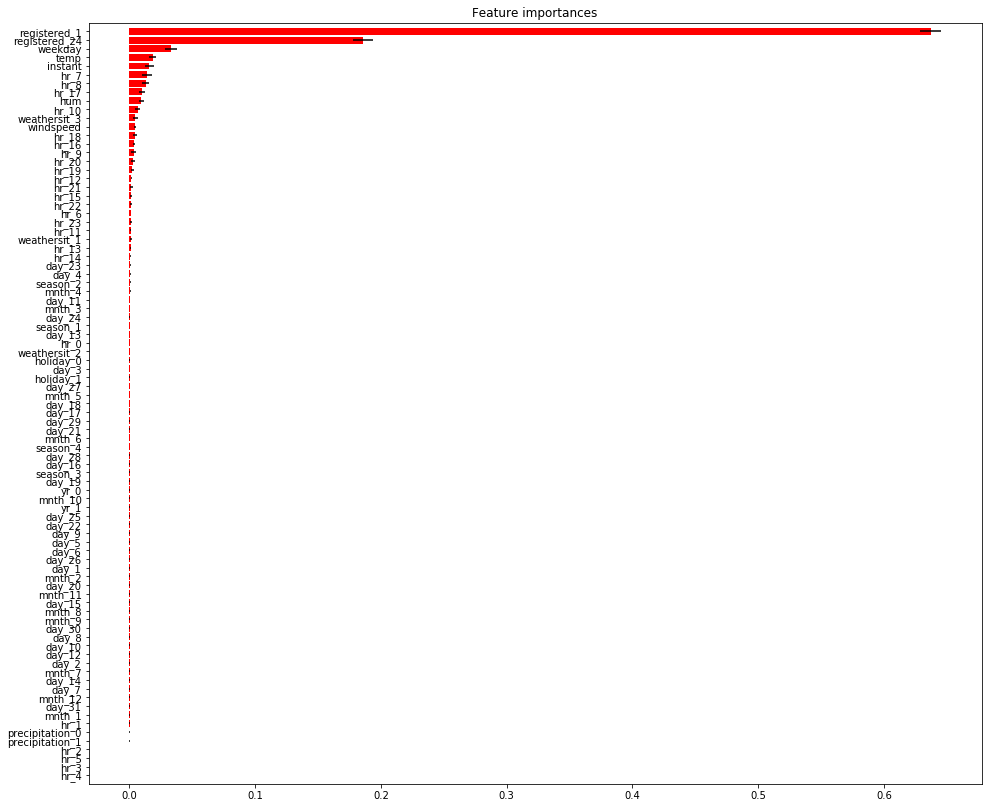

In [21]:
hp.feature_importance(data, RandomForestRegressor(n_estimators=ESTIMATORS, random_state = SEED))

## Principal Component Analysis (PCA)

We plot PCA component variance to define the amount we wish to consider in the pipeline

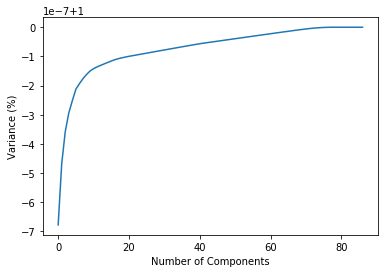

In [22]:
hp.plot_pca_components(data)

## Modeling / Pipeline

The feature engineering pipeline will decide which functions to keep and which not to based on if they improve the score it obtains while cross validating through the different models and transformers

Here we run it with many different models and transformers, as was previously stated, only the best performing ones will be kept

Two different models are created, one to predict weekend usage and another one to predict working days usage, since we see in the data exploration process how different those two behaviours are

The pipeline uses the cross evaluation function, which handles time series splits for fold creation (instead of Kfolds which does not work for time series) while also setting a holdout to perform after the cross validation

It also uses RandomizedSearchCV for hyperparameter tuning if required

In [23]:
models = [
    {'name':'linear_regression', 'model': LinearRegression()},
    {'name':'random_forest', 'model': RandomForestRegressor(n_estimators = ESTIMATORS, random_state = SEED)},
    {'name':'gradient_boosting', 'model': GradientBoostingRegressor(n_estimators = ESTIMATORS, random_state = SEED)},
    {'name':'adaboost', 'model': AdaBoostRegressor(random_state = SEED)},
    {'name':'xgb', 'model': XGBRegressor(seed = SEED)}
]

transformers = [
    {'name':'rfe', 'transformer': RFE(LinearRegression())},
    {'name':'rfe', 'transformer': RFE(RandomForestRegressor(random_state = SEED))},
    {'name':'feature_selection', 'transformer': SelectFromModel(LinearRegression())},
    {'name':'feature_selection', 'transformer': SelectFromModel(RandomForestRegressor(random_state = SEED))},
    {'name':'binning', 'transformer': KBinsDiscretizer(n_bins=5, encode='onehot')},
    {'name':'binning', 'transformer': KBinsDiscretizer(n_bins=6, encode='onehot')},
    {'name':'polynomial', 'transformer': PolynomialFeatures(degree=2, include_bias=False)},
    {'name':'polynomial', 'transformer': PolynomialFeatures(degree=3, include_bias=False)},
    {'name':'pca', 'transformer': PCA(.90)},
    {'name':'pca', 'transformer': PCA(.95)},
    {'name':'gp', 'transformer': SymbolicTransformer(population_size=750, metric='spearman', function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'max', 'min'],parsimony_coefficient=0.0005,max_samples=0.9,random_state=SEED)}
]

pipelines_we, all_we_scores = hp.feature_engineering_pipeline(data.loc[data['weekday'].isin([0,6])], models, transformers)
print('Best pipeline for weekend prediction: \n' + str(pipelines_we[0]['pipeline']))

pipelines_wd, all_wd_scores = hp.feature_engineering_pipeline(data.loc[~data['weekday'].isin([0,6])], models, transformers)
print('Best pipeline for working days prediction: \n' + str(pipelines_wd[0]['pipeline']))

Best pipeline for weekend prediction: 
Pipeline(memory='/var/folders/57/xv08qnd12117z955vhn8xn0w0000gn/T/tmpwcjdxgcd',
     steps=[('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False))])
Best pipeline for working days prediction: 
Pipeline(memory='/var/folders/57/xv08qnd12117z955vhn8xn0w0000gn/T/tmp8m15tsue',
     steps=[('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50

## Randomized Grid Search and final models definition

In [24]:
grid = {
    'randomforestregressor__criterion': ['mse', 'mae'],
    'randomforestregressor__max_depth': [10, 30],
    'randomforestregressor__min_samples_leaf': [2, 4],
    'randomforestregressor__min_samples_split': [5, 10],
    'randomforestregressor__max_leaf_nodes': [20, 50],
}

we_holdout_score, we_scores, we_model = hp.cv_evaluate(data.loc[data['weekday'].isin([0,6])], model = clone(pipelines_we[0]['pipeline']), grid = grid)
score = {'Model': pipelines_we[0]['name'], 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(we_scores[we_scores > 0.0]),np.std(we_scores[we_scores > 0.0])), 'Holdout Score': "{0:.3f}".format(we_holdout_score), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
all_we_scores = all_we_scores.append(score, ignore_index=True)

wd_holdout_score, wd_scores, wd_model = hp.cv_evaluate(data.loc[~data['weekday'].isin([0,6])], model = clone(pipelines_wd[0]['pipeline']), grid = grid)
score = {'Model': pipelines_we[0]['name'], 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(wd_scores[wd_scores > 0.0]),np.std(wd_scores[wd_scores > 0.0])), 'Holdout Score': "{0:.3f}".format(wd_holdout_score), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
all_wd_scores = all_wd_scores.append(score, ignore_index=True)

## Scores

Here you can see all of the scores, first with a baseline (with a simple linear regression) and then throughout the entire cross validation process for each model and each transformer, in certain cases errors do happen (for example when a certain fold contains a sparse matrix), therefore you will see errors marked as such in the score

In [25]:
all_we_scores

,Model,Function,CV Score,Holdout Score,Difference,Outcome
0,random_forest,base_score,0.79 +/- 0.092,0.904225,0,Base random_forest
1,random_forest,rfe,0.61 +/- 0.0,0.816861,-0.087364,Rejected
2,random_forest,feature_selection,0.78 +/- 0.094,-0.0148229,-0.919048,Rejected
3,random_forest,binning,0.66 +/- 0.087,0.745943,-0.158282,Rejected
4,random_forest,polynomial,0.78 +/- 0.068,0.890804,-0.0134209,Rejected
5,random_forest,pca,0.00 +/- 0.0,-0.642664,-1.54689,Rejected
6,random_forest,cross_evaluate,0.778 +/- 0.014,0.891,0,Final Cross Validation


In [26]:
all_wd_scores

,Model,Function,CV Score,Holdout Score,Difference,Outcome
0,random_forest,base_score,0.87 +/- 0.041,0.934213,0,Base random_forest
1,random_forest,rfe,0.59 +/- 0.24,0.357148,-0.577065,Rejected
2,random_forest,feature_selection,0.37 +/- 0.37,-0.0392201,-0.973433,Rejected
3,random_forest,binning,0.61 +/- 0.093,0.639348,-0.294865,Rejected
4,random_forest,polynomial,0.84 +/- 0.053,0.926503,-0.00771003,Rejected
5,random_forest,pca,0.00 +/- 0.0,-1.38937,-2.32358,Rejected
6,random_forest,cross_evaluate,0.803 +/- 0.027,0.890,0,Final Cross Validation


### Best Parameters for the models

In [27]:
print(we_model.best_params_)
print(wd_model.best_params_)
final_we_model = we_model.best_estimator_
final_wd_model = wd_model.best_estimator_

{'randomforestregressor__min_samples_split': 10, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_leaf_nodes': 50, 'randomforestregressor__max_depth': 30, 'randomforestregressor__criterion': 'mse'}
{'randomforestregressor__min_samples_split': 5, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_leaf_nodes': 50, 'randomforestregressor__max_depth': 10, 'randomforestregressor__criterion': 'mse'}


# Final Score
This is the final R^2 score of the model tested against the holdout set

In [28]:
def predict(df, holdout_df, model):
    X_train = df.loc[:, df.columns != TARGET_VARIABLE]
    y_train = df.loc[:, TARGET_VARIABLE]
    model.fit(X_train, y_train)
    
    X = holdout_df.loc[:, holdout_df.columns != TARGET_VARIABLE]
    y = holdout_df.loc[:, TARGET_VARIABLE]
    pred = pd.DataFrame(model.predict(X), columns = ['pred'])
    return pred.set_index(y.index)

y_we_preds = predict(data.loc[data['weekday'].isin([0,6])], holdout.loc[holdout['weekday'].isin([0,6])], final_we_model)
y_wd_preds = predict(data.loc[~data['weekday'].isin([0,6])], holdout.loc[~holdout['weekday'].isin([0,6])], final_wd_model)

final_holdout = pd.merge(holdout, y_we_preds,how = 'left',left_index = True, right_index = True, suffixes=('',''))
final_holdout.loc[~holdout['weekday'].isin([0,6]), 'pred'] = y_wd_preds

y = holdout.loc[:, TARGET_VARIABLE]
pred = final_holdout['pred']
score = metric_scorer(y, pred)
print(score)

0.8971017926810866


## Plots of Predictions

Here we plot the different results obtained

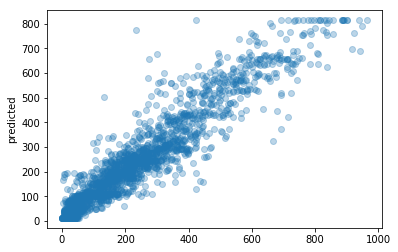

In [29]:
plt.scatter(y, pred, alpha=0.3)
plt.ylabel('predicted')
plt.show()

### Three week prediction vs. reality plot

Text(0, 0.5, 'Users')

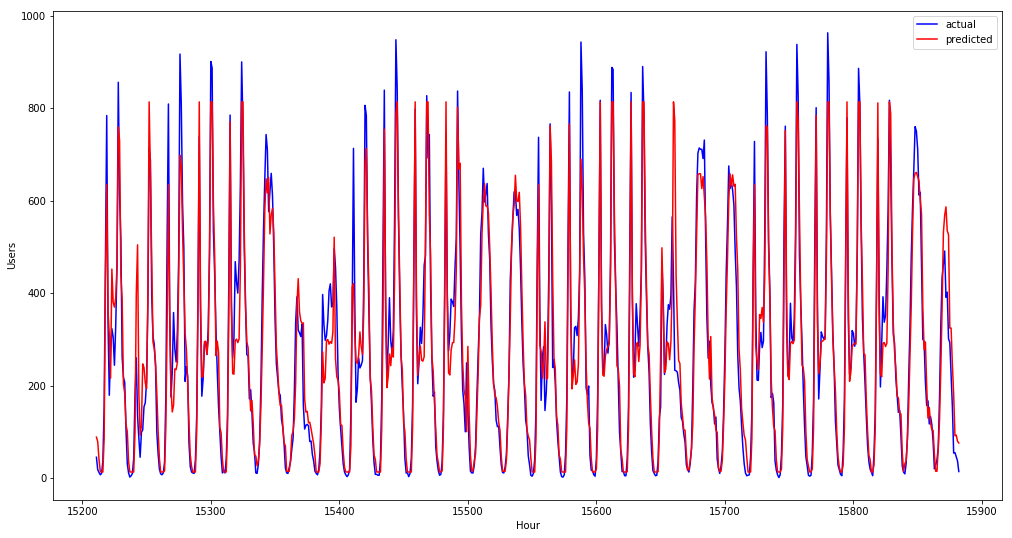

In [30]:
holdout_final_plots['pred'] = pred
plt.figure(figsize=(17, 9))
ax = sns.lineplot(data = y[0:672], color='blue', label = 'actual')
ax = sns.lineplot(data = pred[0:672], color='red', label = 'predicted')

plt.xlabel('Hour')
plt.ylabel('Users')

### Entire prediction vs. reality plot

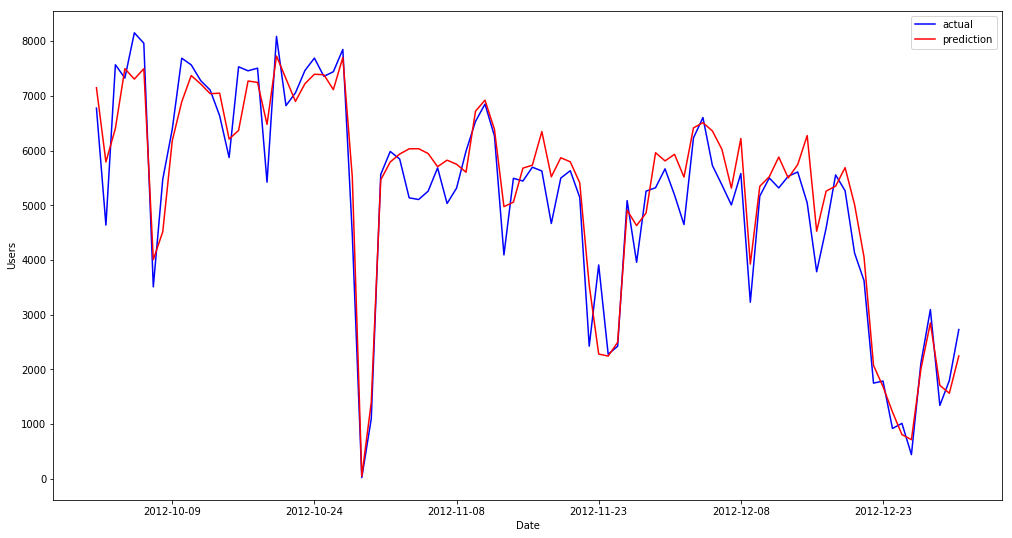

In [31]:
holdout_daily = pd.DataFrame(holdout_final_plots.groupby(["dteday"])[["pred", 'cnt']].sum()).reset_index()
ax = plt.figure(figsize=(17, 9))
ax = sns.lineplot(data = holdout_daily, x = 'dteday', y = 'cnt', color='blue', label = 'actual')
ax = sns.lineplot(data = holdout_daily, x = 'dteday', y = 'pred', color='red', label = 'prediction')
plt.xlabel('Date')
plt.ylabel('Users')
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

## Conclusions

We created two different models to predict bike usage, with our results we believe that we can provide an accurate estimation of usage which can be of great importance for all of the involved parties.

The two models were created since we determined that there was a great difference in usage from weekends to normal working days, this situation would need to be considered by the company to supply the correct amount of bicicles depending on the day of the week, since the demand changes drastically.

Initially we had a baseline model with an r2 score of 0.765, however, after performing multiple data preparation steps and transformations we achieved a score of 0.897, which proves that our predicting capabilities improved immensely.

When analyzing the data, we found that there are many patterns that we could have used to create even more models to get an even higher accuracy score, specifically the patters of time (based on peak hours) would probably give us great results, however, we felt that our models needed to work on a global scale, and that creating more would make them too specific to this particular case.

With these two models, many different bike-sharing companies accross the world can use them to estimate usage, planify better for expected demand and even help their governments transportation requirements. Measuring the impact of new bike infrastructure on cycling traffic and behavior is top of mind for many planners and advocacy groups.